# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared quantum policy and joint quantum critic.

In [1]:
import sys
sys.path.append('../') # Use parent dir.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import numpy as np
import cirq
import functools as ft
from datetime import datetime

2024-05-03 12:35:14.936391: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [5]:
output_dir = Path('./output/')
root_dir = output_dir/'coingame_maa2c_quantum_mdp_central'
root_dir.expanduser().mkdir(parents=True, exist_ok=True)

checkpoint_dir = root_dir / 'checkpoints'

metrics_file = root_dir / 'metrics-{datetime}.json'
model_actor_checkpoint_file = checkpoint_dir / 'actor' / 'cp-{datetime}.ckpt'
model_critic_checkpoint_file = checkpoint_dir / 'critic' / 'cp-{datetime}.ckpt'

In [6]:
n_actions = 4
n_agents = 2
observation_dim = 36

In [7]:
n_layers = 5


# Quantum shared actor.
model_actor = eqmarl.models.generate_model_CoinGame2_actor_quantum_shared_mdp(
    n_layers=n_layers,
    squash_activation='arctan',
    name=f"actor-quantum-shared",
    )
optimizer_actor = [
    keras.optimizers.Adam(learning_rate=1e-2),
    keras.optimizers.Adam(learning_rate=1e-1),
    keras.optimizers.Adam(learning_rate=1e-1),
    ]

model_actor.build((None, observation_dim))
model_actor.summary()


# Quantum joint critic.
model_critic = eqmarl.models.generate_model_CoinGame2_critic_quantum_central_mdp(
    n_agents=n_agents,
    n_layers=n_layers,
    squash_activation='arctan',
    name=f"critic-quantum-joint-central",
    )
optimizer_critic = [
    keras.optimizers.Adam(learning_rate=1e-2),
    keras.optimizers.Adam(learning_rate=1e-1),
    keras.optimizers.Adam(learning_rate=1e-1),
    ]

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "actor-quantum-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 4, 3)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 4)                132       
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-policy (Sequent  (None, 4)                4         
 ial)                                                            
                                                                 
Total params: 136
Trainable params: 136
Non-trainable params: 0
_________________________________________________________________
Model: "critic-quantum-joint-central"
__________

In [8]:
model_actor.trainable_variables

[<tf.Variable 'w_var:0' shape=(6, 4, 3) dtype=float32, numpy=
 array([[[1.4600681 , 1.9478902 , 1.0179112 ],
         [2.3505957 , 2.000865  , 1.7763547 ],
         [0.8367562 , 1.1161404 , 1.9948541 ],
         [2.7682393 , 1.883988  , 1.9469396 ]],
 
        [[1.6544522 , 0.2887805 , 2.2687876 ],
         [0.6089638 , 1.2591203 , 3.0470212 ],
         [1.7618781 , 1.6010704 , 1.4786111 ],
         [2.432642  , 2.4349318 , 0.16299745]],
 
        [[1.4357922 , 2.5329049 , 0.94688714],
         [1.4283264 , 2.253669  , 1.3976648 ],
         [2.219646  , 0.6377484 , 1.6896555 ],
         [0.41331157, 2.5856564 , 1.1896703 ]],
 
        [[0.46102867, 0.372354  , 0.9079354 ],
         [1.8232067 , 0.370923  , 1.6963135 ],
         [0.7217477 , 1.7094868 , 0.74922645],
         [0.93650955, 2.1735234 , 2.9640715 ]],
 
        [[0.7556623 , 1.1154239 , 0.67849517],
         [2.9381287 , 0.98692715, 2.4465804 ],
         [2.7124841 , 1.8092116 , 0.33925056],
         [2.1376653 , 1.0053481 ,

In [9]:
model_critic.trainable_variables

[<tf.Variable 'w_var:0' shape=(6, 8, 3) dtype=float32, numpy=
 array([[[2.7905617 , 1.7122005 , 2.8258371 ],
         [0.4304891 , 3.060444  , 2.7884872 ],
         [2.9872777 , 1.1166459 , 0.74534017],
         [2.4330232 , 1.1555411 , 0.47644335],
         [2.9501565 , 0.89511603, 2.0605097 ],
         [1.4629447 , 1.3157645 , 1.623354  ],
         [0.13683738, 2.8565862 , 0.2498902 ],
         [2.6293416 , 0.94966185, 0.18047793]],
 
        [[1.2709169 , 1.086715  , 2.1038423 ],
         [2.0659857 , 0.98898506, 1.5783045 ],
         [2.691905  , 1.1999913 , 0.9083556 ],
         [1.8330715 , 2.3017254 , 1.7480011 ],
         [2.9736264 , 1.3741903 , 0.6315979 ],
         [1.9134426 , 1.4805627 , 1.5813755 ],
         [0.18299425, 1.8668094 , 2.6712134 ],
         [1.4354395 , 0.6601683 , 0.74838865]],
 
        [[2.3031793 , 0.64508164, 1.1768831 ],
         [2.3687174 , 0.30024153, 0.89156234],
         [2.119004  , 2.779919  , 2.076122  ],
         [1.080849  , 2.748633  , 0.547

In [10]:
# latest_actor = tf.train.latest_checkpoint(model_actor_checkpoint_file.parent)
# print(f"loading checkpoint: {latest_actor}")
# model_actor.load_weights(latest_actor)

# model_actor.trainable_variables

## Training

In [11]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [12]:
# Time of training start.
datetime_start = datetime.now().isoformat()

# Set model checkpoint files to have timestamp of training start.
model_actor_checkpoint_file_current = str(model_actor_checkpoint_file).format(datetime=datetime_start)
model_critic_checkpoint_file_current = str(model_critic_checkpoint_file).format(datetime=datetime_start)
metrics_file_current = str(metrics_file).format(datetime=datetime_start)

# Train models using algorithm.
reward_history, metrics_history = algo.train(
    n_episodes=3000,
    callbacks=[
        eqmarl.AlgorithmResultCheckpoint(filepath=metrics_file_current, save_freq=100, verbose=True),
        # eqmarl.TensorflowModelCheckpoint(model=model_actor, filepath=model_actor_checkpoint_file_current, save_freq=100, verbose=True),
        ],
    )

# Save results to file.
algo.save_train_results(metrics_file_current, reward_history, metrics_history)

Training for 3000 episodes, press 'Ctrl+C' to terminate early
Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 3000: 100%|██████████| 3000/3000 [2:13:31<00:00,  2.67s/episode, coins_collected=22, discounted_reward=17.1, episode_reward=[12. 10.], own_coin_rate=1, own_coins_collected=22, undiscounted_reward=22]


In [13]:
# Save models to file.
datetimestring = datetime.now().isoformat()
model_actor.save_weights(str(model_actor_checkpoint_file).format(datetime=datetimestring))
model_critic.save_weights(str(model_critic_checkpoint_file).format(datetime=datetimestring))

In [14]:
model_actor.trainable_variables

[<tf.Variable 'w_var:0' shape=(6, 4, 3) dtype=float32, numpy=
 array([[[ 1.8532847 ,  2.2499552 ,  0.40502232],
         [ 1.7612453 ,  2.4951193 ,  1.6279719 ],
         [-0.05354623,  0.59586143,  1.6041157 ],
         [ 2.475486  ,  1.7739621 ,  3.1979666 ]],
 
        [[ 2.5591922 ,  0.98778325,  2.2323859 ],
         [ 0.78145653,  1.2605497 ,  2.9611475 ],
         [ 1.0770758 ,  0.7144828 ,  0.13692977],
         [ 2.4506674 ,  2.102957  ,  1.1218133 ]],
 
        [[ 1.3406904 ,  1.9715674 ,  1.3187702 ],
         [ 1.0654454 ,  2.4781263 ,  1.7160201 ],
         [ 2.4396982 ,  0.4871173 ,  2.0424855 ],
         [ 0.64985347,  3.144476  ,  0.65908414]],
 
        [[ 0.77177167,  0.5607487 ,  0.87129515],
         [ 1.155769  ,  0.16823539,  1.6109354 ],
         [ 0.5868703 ,  1.8147719 ,  0.97151864],
         [ 1.6675199 ,  1.5780877 ,  3.0122108 ]],
 
        [[ 1.8691208 ,  1.2611805 ,  0.9619917 ],
         [ 3.327933  ,  0.53500974,  2.077562  ],
         [ 3.754673  ,  0.

In [15]:
model_critic.trainable_variables

[<tf.Variable 'w_var:0' shape=(6, 8, 3) dtype=float32, numpy=
 array([[[ 2.0620046 ,  1.5781724 ,  3.8337038 ],
         [-0.8909464 ,  2.7066996 ,  3.3332489 ],
         [ 0.5278265 , -0.3153238 ,  1.4522582 ],
         [ 1.3031765 ,  1.924789  ,  0.04323884],
         [ 1.8318034 ,  0.9159691 ,  2.4770908 ],
         [-0.8790151 ,  1.7513882 ,  0.13199487],
         [-1.8535475 ,  3.240936  , -0.57626194],
         [ 1.2092562 ,  0.13523191, -0.32295874]],
 
        [[ 1.4126682 ,  1.8543797 ,  2.4441879 ],
         [ 1.6206892 ,  0.34202713,  1.347497  ],
         [ 2.1452062 ,  0.69699275,  0.83233374],
         [ 2.4784844 ,  2.0379364 ,  1.6017652 ],
         [ 3.239478  ,  0.5697592 , -0.35267845],
         [ 1.9352397 ,  1.816882  ,  1.7236726 ],
         [ 0.54538065,  1.6851469 ,  2.1825614 ],
         [ 0.72568655,  0.17463633,  1.2551614 ]],
 
        [[ 3.1558225 ,  0.23830293,  1.0774908 ],
         [ 1.7112303 ,  1.5487353 ,  0.7113859 ],
         [ 2.7577357 ,  2.518554

In [16]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file_current)

Text(0.5, 1.0, 'Score')

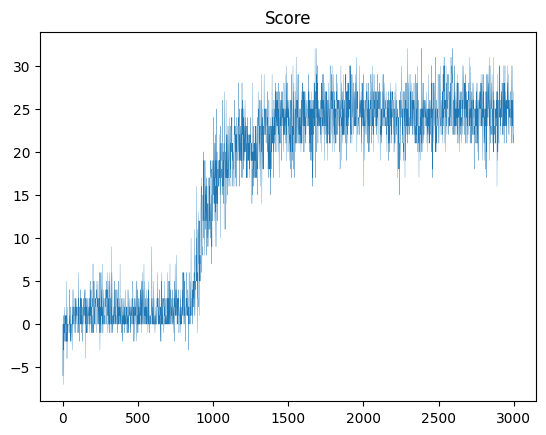

In [17]:
score = np.sum(reward_history, axis=-1)
plt.plot(score, linewidth=.2)
plt.title('Score')

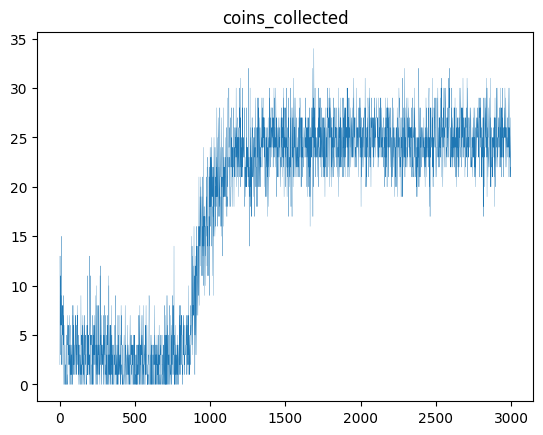

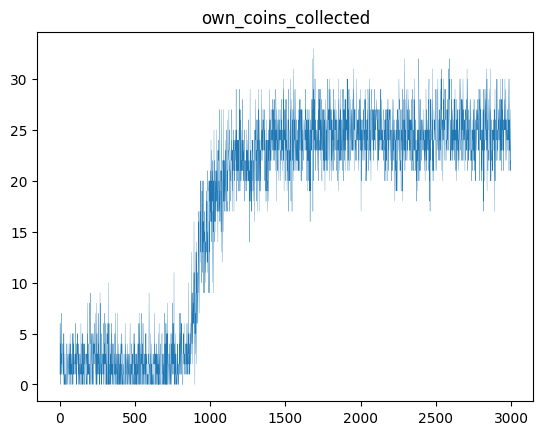

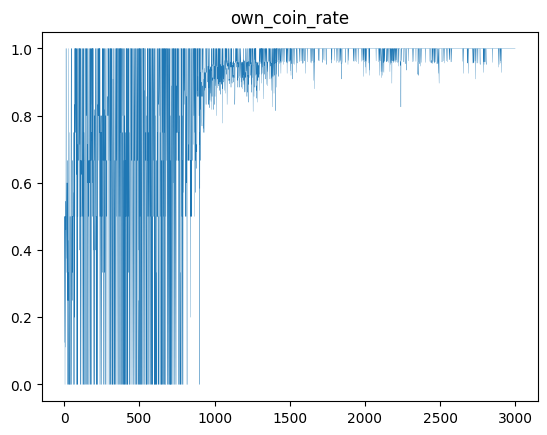

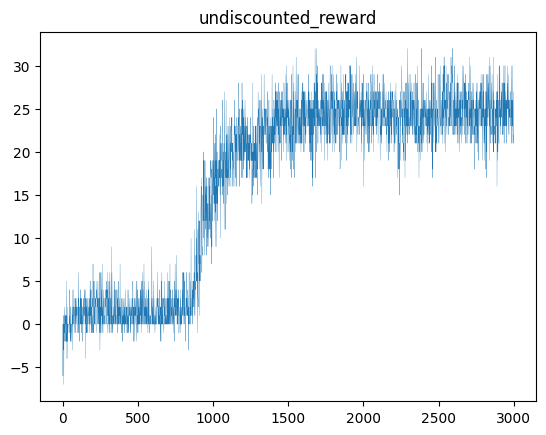

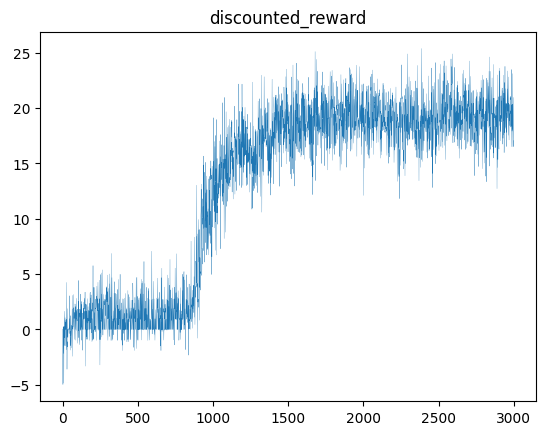

In [18]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v, linewidth=.2)